# Mounting the dataset

In [ ]:
# only if using colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# only if using colab
zip_path = "/content/drive/My Drive/dev_phase.zip"
!mkdir -p /content/dev_phase
!unzip "$zip_path" -d /content/


Archive:  /content/drive/My Drive/dev_phase.zip
   creating: /content/subtask1/
   creating: /content/subtask1/dev/
  inflating: /content/subtask1/dev/nep.csv  
  inflating: /content/subtask1/dev/ita.csv  
  inflating: /content/subtask1/dev/pol.csv  
  inflating: /content/subtask1/dev/rus.csv  
  inflating: /content/subtask1/dev/tel.csv  
  inflating: /content/subtask1/dev/hin.csv  
  inflating: /content/subtask1/dev/hau.csv  
  inflating: /content/subtask1/dev/pan.csv  
  inflating: /content/subtask1/dev/ori.csv  
  inflating: /content/subtask1/dev/spa.csv  
  inflating: /content/subtask1/dev/deu.csv  
  inflating: /content/subtask1/dev/fas.csv  
  inflating: /content/subtask1/dev/arb.csv  
  inflating: /content/subtask1/dev/ben.csv  
  inflating: /content/subtask1/dev/amh.csv  
  inflating: /content/subtask1/dev/khm.csv  
  inflating: /content/subtask1/dev/tur.csv  
  inflating: /content/subtask1/dev/zho.csv  
  inflating: /content/subtask1/dev/eng.csv  
  inflating: /content/subtask

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from textblob import TextBlob


In [ ]:
DATASET_PATH = "./subtask1/train/eng.csv"
df = pd.read_csv(DATASET_PATH)

# -----------------------------------------------
# data = {
#     'id': ['1', '2', '3', '4', '5'],
#     'text': [
#         '"Conservative values" okay junior. Its an oxymoron, and hes just a moron.',
#         'Nazi is a subcategory of fascist',
#         'Theyre not interested in the rights given to 43,000 asylum seekers but with the removal of rights from 70 million citizens',
#         'The weather is quite nice today for a walk.',
#         'You are undeniably the worst president in history, absolutely shameful!'
#     ],
#     'polarization': [1, 0, 1, 0, 1]
# }
# df = pd.DataFrame(data)
# -----------------------------------------------

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (3222, 3)


,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


## Class Distribution

/tmp/ipython-input-776398999.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='polarization', data=df, palette='viridis')


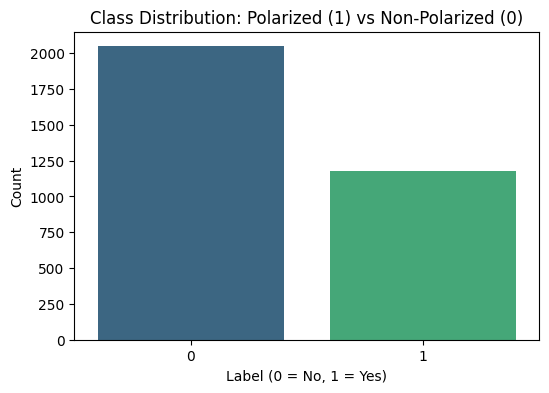

polarization
0    63.531968
1    36.468032
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='polarization', data=df, palette='viridis')
plt.title('Class Distribution: Polarized (1) vs Non-Polarized (0)')
plt.xlabel('Label (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


print(df['polarization'].value_counts(normalize=True) * 100)

## Distribution of word count

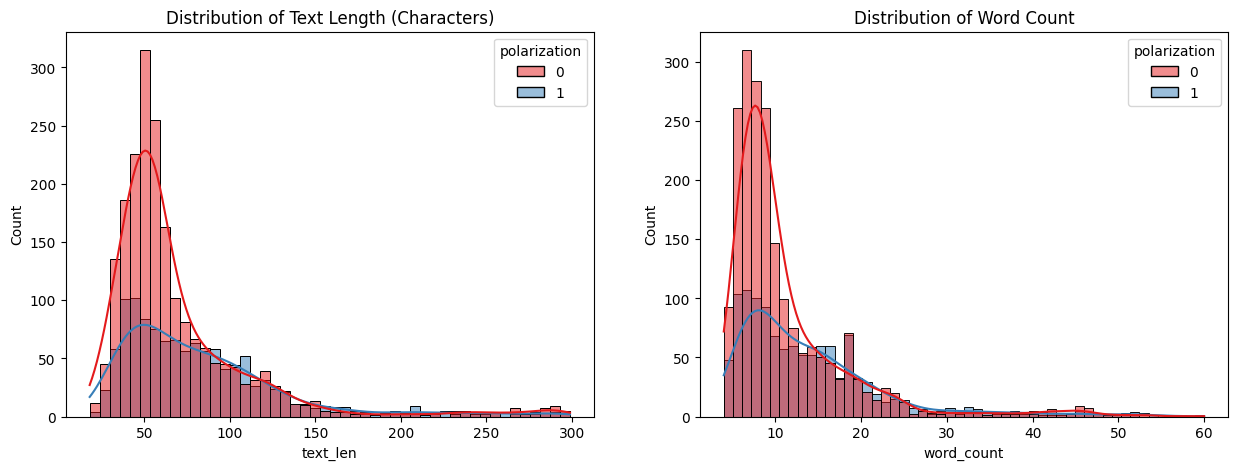

In [ ]:
# Create features for analysis
df['text_len'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character Length
sns.histplot(df, x='text_len', hue='polarization', kde=True, ax=axes[0], palette='Set1')
axes[0].set_title('Distribution of Text Length (Characters)')

# Word Count
sns.histplot(df, x='word_count', hue='polarization', kde=True, ax=axes[1], palette='Set1')
axes[1].set_title('Distribution of Word Count')

plt.show()

## Sentiment Analysis

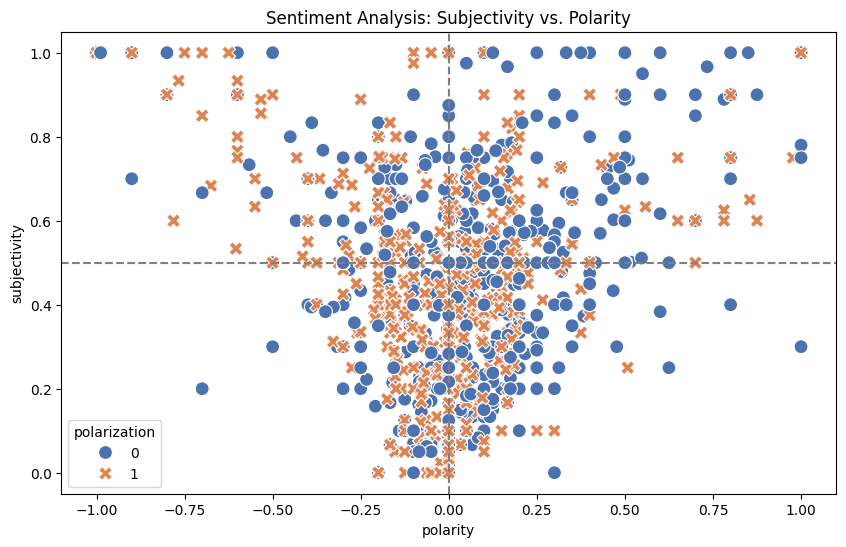

In [ ]:
# Function to get subjectivity (0 = Objective/Fact, 1 = Subjective/Opinion)
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Function to get polarity (-1 = Negative, 1 = Positive)
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['subjectivity'] = df['text'].apply(get_subjectivity)
df['polarity'] = df['text'].apply(get_polarity)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='polarity', y='subjectivity', hue='polarization', style='polarization', s=100, palette='deep')
plt.title('Sentiment Analysis: Subjectivity vs. Polarity')
plt.axvline(0, color='grey', linestyle='--') # Neutral polarity line
plt.axhline(0.5, color='grey', linestyle='--') # Subjectivity threshold
plt.show()

## Common Words

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from collections import Counter
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # (Noise words to ignore)


# Helper function to clean text and get top words
def get_clean_top_words(text_series, top_k=10):
    all_words = []

    for text in text_series:
        text = text.lower()

        # Remove punctuation using Regex
        # This keeps only letters (a-z) and numbers
        text = re.sub(r'[^\w\s]', '', text)

        # Split into words
        words = text.split()

        # Add to list ONLY if not a stopword
        for word in words:
            if word not in stop_words and len(word) > 2: # skip 1-2 letter bugs
                all_words.append(word)

    return Counter(all_words).most_common(top_k)

polarized_text = df[df['polarization'] == 1]['text']
non_polarized_text = df[df['polarization'] == 0]['text']

top_pol_words = get_clean_top_words(polarized_text)
top_non_pol_words = get_clean_top_words(non_polarized_text)

print("--- TOP WORDS IN POLARIZED TEXT ---")
for word, count in top_pol_words:
    print(f"{word}: {count}")

print("\n--- TOP WORDS IN NON-POLARIZED TEXT ---")
for word, count in top_non_pol_words:
    print(f"{word}: {count}")

--- TOP WORDS IN POLARIZED TEXT ---
state: 91
election: 89
trump: 83
like: 61
states: 56
people: 55
immigration: 44
israel: 42
apartheid: 40
ukraine: 39

--- TOP WORDS IN NON-POLARIZED TEXT ---
gaza: 126
gop: 125
trump: 125
ukraine: 121
donald: 92
military: 82
biden: 80
war: 78
harris: 78
aid: 77


## Absolutist word count

In [ ]:
absolutist_words = {
    "always", "never", "completely", "totally", "absolutely", "entirely",
    "forever", "nothing", "everyone", "no one", "must", "should", "all",
    "none", "perfect", "terrible", "worst", "best", "disaster", "awful",
    "ruined", "failure", "hopeless", "everybody", "everything", "impossible",
    "only", "entire", "constant", "definitely"
}


def count_absolutist(text):
    count = 0
    for word in text.lower().split():
        if word in absolutist_words:
            count += 1
    return count

df['absolutist_count'] = df['text'].apply(count_absolutist)

# Check average absolutist words per class
print("\nAverage Absolutist Words per Class:")
print(df.groupby('polarization')['absolutist_count'].mean())


Average Absolutist Words per Class:
polarization
0    0.089888
1    0.184681
Name: absolutist_count, dtype: float64


# EDA 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# ==================== CONFIGURATION ====================
LANGUAGE = 'eng'  # Change to 'swa' or 'amh'
OUTPUT_DIR = f'eda_results_{LANGUAGE}'

# Absolutist words (indicators of polarization)
ABSOLUTIST_WORDS = [
    'always', 'never', 'all', 'none', 'every', 'nothing', 'everything', 'everyone',
    'nobody', 'everywhere', 'nowhere', 'completely', 'absolutely', 'totally',
    'entirely', 'whole', 'forever', 'constant', 'must', 'cannot', 'impossible',
    'definitely', 'certainly', 'obviously', 'clearly', 'undoubtedly', 'without doubt'
]

# Emotional intensity words
INTENSITY_WORDS = [
    'extremely', 'very', 'incredibly', 'absolutely', 'utterly', 'completely',
    'totally', 'highly', 'deeply', 'profoundly', 'severely', 'massively',
    'enormously', 'tremendously', 'exceedingly', 'exceptionally'
]

# Hate/Negative words indicators
HATE_INDICATORS = [
    'hate', 'stupid', 'idiot', 'fool', 'garbage', 'trash', 'disgusting',
    'pathetic', 'worst', 'terrible', 'awful', 'horrible', 'evil', 'destroy',
    'kill', 'die', 'death', 'threat', 'attack', 'violent', 'violence'
]

# Us vs Them words
US_THEM_WORDS = {
    'us': ['we', 'us', 'our', 'ours', 'ourselves'],
    'them': ['they', 'them', 'their', 'theirs', 'themselves', 'those people', 'these people']
}

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==================== TEXT ANALYSIS FUNCTIONS ====================
def get_text_stats(text):
    """Calculate basic text statistics"""
    if pd.isna(text):
        return {
            'word_count': 0, 'char_count': 0, 'avg_word_length': 0,
            'sentence_count': 0, 'exclamation_count': 0, 'question_count': 0,
            'capital_ratio': 0, 'digit_count': 0
        }

    text_str = str(text)
    words = text_str.split()

    return {
        'word_count': len(words),
        'char_count': len(text_str),
        'avg_word_length': np.mean([len(w) for w in words]) if words else 0,
        'sentence_count': len(re.findall(r'[.!?]+', text_str)),
        'exclamation_count': text_str.count('!'),
        'question_count': text_str.count('?'),
        'capital_ratio': sum(1 for c in text_str if c.isupper()) / len(text_str) if text_str else 0,
        'digit_count': sum(1 for c in text_str if c.isdigit())
    }

def count_absolutist_words(text):
    """Count absolutist words in text"""
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return sum(1 for word in ABSOLUTIST_WORDS if f' {word} ' in f' {text_lower} ')

def count_intensity_words(text):
    """Count emotional intensity words"""
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return sum(1 for word in INTENSITY_WORDS if f' {word} ' in f' {text_lower} ')

def count_hate_indicators(text):
    """Count hate/negative indicators"""
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return sum(1 for word in HATE_INDICATORS if word in text_lower)

def count_us_them(text):
    """Count us vs them language"""
    if pd.isna(text):
        return {'us_count': 0, 'them_count': 0, 'ratio': 0}
    text_lower = str(text).lower()

    us_count = sum(1 for word in US_THEM_WORDS['us'] if f' {word} ' in f' {text_lower} ')
    them_count = sum(1 for word in US_THEM_WORDS['them'] if f' {word} ' in f' {text_lower} ')

    return {
        'us_count': us_count,
        'them_count': them_count,
        'ratio': (us_count - them_count) / max(us_count + them_count, 1)
    }

def get_sentiment(text):
    """Get sentiment polarity and subjectivity"""
    if pd.isna(text):
        return {'polarity': 0, 'subjectivity': 0}
    try:
        blob = TextBlob(str(text))
        return {
            'polarity': blob.sentiment.polarity,
            'subjectivity': blob.sentiment.subjectivity
        }
    except:
        return {'polarity': 0, 'subjectivity': 0}

def extract_ngrams(texts, n=2, top_k=20):
    """Extract top n-grams"""
    all_ngrams = []
    for text in texts:
        if pd.isna(text):
            continue
        words = str(text).lower().split()
        ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
        all_ngrams.extend(ngrams)

    return Counter(all_ngrams).most_common(top_k)

def get_most_common_words(texts, top_k=30, remove_stopwords=True):
    """Get most common words"""
    all_words = []
    stop_words = set(stopwords.words('english')) if remove_stopwords else set()

    for text in texts:
        if pd.isna(text):
            continue
        words = re.findall(r'\b[a-z]+\b', str(text).lower())
        words = [w for w in words if len(w) > 2 and (not remove_stopwords or w not in stop_words)]
        all_words.extend(words)

    return Counter(all_words).most_common(top_k)

# ==================== SUBTASK 1: BINARY CLASSIFICATION ====================
def analyze_subtask1(language):
    """Comprehensive EDA for Subtask 1"""
    print(f"\n{'='*80}")
    print(f"SUBTASK 1 ANALYSIS - {language.upper()}")
    print(f"{'='*80}")

    # Load data
    train_path = f'./subtask1/train/{language}.csv'
    if not os.path.exists(train_path):
        print("bitch")
        return "bitch"
    df = pd.read_csv(train_path)
    df['text'].apply(clean_text)

    # Create polarization column if needed
    if 'polarization' not in df.columns:
        old_labels = ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']
        is_polarized = df[old_labels].sum(axis=1) > 0
        df['polarization'] = np.where(is_polarized, 0, 1)

    print(f"\nDataset shape: {df.shape}")
    print(f"\nClass distribution:")
    print(df['polarization'].value_counts())
    print(f"\nClass balance:")
    print(df['polarization'].value_counts(normalize=True))

    # Text statistics
    print(f"\nCalculating text statistics...")
    text_stats = df['text'].apply(get_text_stats)
    for key in text_stats.iloc[0].keys():
        df[key] = text_stats.apply(lambda x: x[key])

    # Linguistic features
    df['absolutist_count'] = df['text'].apply(count_absolutist_words)
    df['intensity_count'] = df['text'].apply(count_intensity_words)
    df['hate_indicators'] = df['text'].apply(count_hate_indicators)

    us_them = df['text'].apply(count_us_them)
    df['us_count'] = us_them.apply(lambda x: x['us_count'])
    df['them_count'] = us_them.apply(lambda x: x['them_count'])
    df['us_them_ratio'] = us_them.apply(lambda x: x['ratio'])

    sentiment = df['text'].apply(get_sentiment)
    df['polarity'] = sentiment.apply(lambda x: x['polarity'])
    df['subjectivity'] = sentiment.apply(lambda x: x['subjectivity'])

    # Visualizations
    output_dir = f'{OUTPUT_DIR}/subtask1'
    os.makedirs(output_dir, exist_ok=True)

    # 1. Class distribution
    fig, ax = plt.subplots(figsize=(8, 6))
    df['polarization'].value_counts().plot(kind='bar', ax=ax, color=['salmon', 'lightblue'])
    ax.set_xlabel('Polarization (0=Polarized, 1=Not Polarized)')
    ax.set_ylabel('Count')
    ax.set_title(f'{language.upper()} - Class Distribution')
    ax.set_xticklabels(['Polarized', 'Not Polarized'], rotation=0)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/class_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Text length comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    features = ['word_count', 'char_count', 'sentence_count', 'avg_word_length']
    titles = ['Word Count', 'Character Count', 'Sentence Count', 'Avg Word Length']

    for idx, (feature, title) in enumerate(zip(features, titles)):
        ax = axes[idx // 2, idx % 2]
        df.boxplot(column=feature, by='polarization', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Polarization')
        ax.set_ylabel(title)
        plt.sca(ax)
        plt.xticks([1, 2], ['Polarized', 'Not Polarized'])

    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/text_length_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Linguistic features comparison
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    linguistic_features = [
        ('absolutist_count', 'Absolutist Words'),
        ('intensity_count', 'Intensity Words'),
        ('hate_indicators', 'Hate Indicators'),
        ('exclamation_count', 'Exclamation Marks'),
        ('capital_ratio', 'Capital Letter Ratio'),
        ('us_them_ratio', 'Us vs Them Ratio')
    ]

    for idx, (feature, title) in enumerate(linguistic_features):
        ax = axes[idx // 3, idx % 3]
        df.boxplot(column=feature, by='polarization', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Polarization')
        plt.sca(ax)
        plt.xticks([1, 2], ['Polarized', 'Not Polarized'])

    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/linguistic_features.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Sentiment analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for idx, feature in enumerate(['polarity', 'subjectivity']):
        ax = axes[idx]
        df.boxplot(column=feature, by='polarization', ax=ax)
        ax.set_title(feature.capitalize())
        ax.set_xlabel('Polarization')
        plt.sca(ax)
        plt.xticks([1, 2], ['Polarized', 'Not Polarized'])

    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/sentiment_analysis.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Word clouds
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for idx, (label, title) in enumerate([(0, 'Polarized'), (1, 'Not Polarized')]):
        texts = ' '.join(df[df['polarization'] == label]['text'].dropna().astype(str))
        if texts:
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 max_words=100, colormap='viridis').generate(texts)
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].set_title(f'{title} Texts - Word Cloud')
            axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/wordclouds.pdf', dpi=300, bbox_inches='tight')
    plt.close()

    # 6. Top words comparison
    polarized_words = get_most_common_words(df[df['polarization'] == 0]['text'], top_k=20)
    not_polarized_words = get_most_common_words(df[df['polarization'] == 1]['text'], top_k=20)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    words, counts = zip(*polarized_words) if polarized_words else ([], [])
    axes[0].barh(range(len(words)), counts, color='salmon')
    axes[0].set_yticks(range(len(words)))
    axes[0].set_yticklabels(words)
    axes[0].set_xlabel('Frequency')
    axes[0].set_title('Top 20 Words - Polarized Texts')
    axes[0].invert_yaxis()

    words, counts = zip(*not_polarized_words) if not_polarized_words else ([], [])
    axes[1].barh(range(len(words)), counts, color='lightblue')
    axes[1].set_yticks(range(len(words)))
    axes[1].set_yticklabels(words)
    axes[1].set_xlabel('Frequency')
    axes[1].set_title('Top 20 Words - Not Polarized Texts')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_words.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 7. Bigrams
    polarized_bigrams = extract_ngrams(df[df['polarization'] == 0]['text'], n=2, top_k=15)
    not_polarized_bigrams = extract_ngrams(df[df['polarization'] == 1]['text'], n=2, top_k=15)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    if polarized_bigrams:
        bigrams, counts = zip(*polarized_bigrams)
        axes[0].barh(range(len(bigrams)), counts, color='salmon')
        axes[0].set_yticks(range(len(bigrams)))
        axes[0].set_yticklabels(bigrams, fontsize=9)
        axes[0].set_xlabel('Frequency')
        axes[0].set_title('Top 15 Bigrams - Polarized Texts')
        axes[0].invert_yaxis()

    if not_polarized_bigrams:
        bigrams, counts = zip(*not_polarized_bigrams)
        axes[1].barh(range(len(bigrams)), counts, color='lightblue')
        axes[1].set_yticks(range(len(bigrams)))
        axes[1].set_yticklabels(bigrams, fontsize=9)
        axes[1].set_xlabel('Frequency')
        axes[1].set_title('Top 15 Bigrams - Not Polarized Texts')
        axes[1].invert_yaxis()

    plt.tight_layout()
    plt.savefig(f'{output_dir}/bigrams.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Summary statistics
    print(f"\nSummary Statistics:")
    summary_cols = ['word_count', 'absolutist_count', 'intensity_count', 'hate_indicators',
                   'polarity', 'subjectivity', 'capital_ratio']
    summary = df.groupby('polarization')[summary_cols].mean()
    print(summary)

    # Save summary
    summary.to_csv(f'{output_dir}/summary_statistics.csv')
    print(f"\nResults saved to {output_dir}/")

# ==================== SUBTASK 2: MULTI-LABEL POLARIZATION ====================
def analyze_subtask2(language):
    """Comprehensive EDA for Subtask 2"""
    print(f"\n{'='*80}")
    print(f"SUBTASK 2 ANALYSIS - {language.upper()}")
    print(f"{'='*80}")

    # Load data
    train_path = f'./subtask2/train/{language}.csv'
    df = pd.read_csv(train_path)
    df['text'].apply(clean_text)

    label_columns = ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']

    print(f"\nDataset shape: {df.shape}")
    print(f"\nLabel distribution:")
    for label in label_columns:
        count = df[label].sum()
        print(f"  {label:20s}: {count} ({count/len(df)*100:.1f}%)")

    # Multi-label statistics
    df['num_labels'] = df[label_columns].sum(axis=1)
    df['has_polarization'] = (df['num_labels'] > 0).astype(int)

    print(f"\nMulti-label statistics:")
    print(f"  Texts with no labels: {(df['num_labels'] == 0).sum()}")
    print(f"  Texts with 1 label:   {(df['num_labels'] == 1).sum()}")
    print(f"  Texts with 2+ labels: {(df['num_labels'] >= 2).sum()}")
    print(f"  Max labels per text:  {df['num_labels'].max()}")

    # Text statistics
    print(f"\nCalculating text statistics...")
    text_stats = df['text'].apply(get_text_stats)
    for key in text_stats.iloc[0].keys():
        df[key] = text_stats.apply(lambda x: x[key])

    # Linguistic features
    df['absolutist_count'] = df['text'].apply(count_absolutist_words)
    df['intensity_count'] = df['text'].apply(count_intensity_words)
    df['hate_indicators'] = df['text'].apply(count_hate_indicators)

    sentiment = df['text'].apply(get_sentiment)
    df['polarity'] = sentiment.apply(lambda x: x['polarity'])
    df['subjectivity'] = sentiment.apply(lambda x: x['subjectivity'])

    # Visualizations
    output_dir = f'{OUTPUT_DIR}/subtask2'
    os.makedirs(output_dir, exist_ok=True)

    # 1. Label distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    label_counts = [df[label].sum() for label in label_columns]
    ax.bar(range(len(label_columns)), label_counts, color='steelblue', alpha=0.7)
    ax.set_xticks(range(len(label_columns)))
    ax.set_xticklabels(label_columns, rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title(f'{language.upper()} - Polarization Type Distribution')
    for i, count in enumerate(label_counts):
        ax.text(i, count + max(label_counts)*0.01, str(count), ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Number of labels per text
    fig, ax = plt.subplots(figsize=(10, 6))
    df['num_labels'].value_counts().sort_index().plot(kind='bar', ax=ax, color='coral', alpha=0.7)
    ax.set_xlabel('Number of Labels')
    ax.set_ylabel('Count')
    ax.set_title(f'{language.upper()} - Multi-Label Distribution')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/multilabel_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Label co-occurrence matrix
    cooccurrence = np.zeros((len(label_columns), len(label_columns)))
    for i, label1 in enumerate(label_columns):
        for j, label2 in enumerate(label_columns):
            cooccurrence[i, j] = ((df[label1] == 1) & (df[label2] == 1)).sum()

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cooccurrence, annot=True, fmt='.0f', cmap='YlOrRd',
                xticklabels=label_columns, yticklabels=label_columns, ax=ax)
    ax.set_title(f'{language.upper()} - Label Co-occurrence Matrix')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/label_cooccurrence.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 4. Text length by number of labels
    fig, ax = plt.subplots(figsize=(10, 6))
    df.boxplot(column='word_count', by='num_labels', ax=ax)
    ax.set_xlabel('Number of Labels')
    ax.set_ylabel('Word Count')
    ax.set_title(f'{language.upper()} - Text Length by Number of Labels')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/text_length_by_labels.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 5. Linguistic features by label
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    features = ['absolutist_count', 'intensity_count', 'hate_indicators',
               'polarity', 'subjectivity', 'capital_ratio']

    for idx, feature in enumerate(features):
        ax = axes[idx // 3, idx % 3]
        data_to_plot = [df[df[label] == 1][feature].dropna() for label in label_columns]
        ax.boxplot(data_to_plot, labels=[l.split('/')[0][:8] for l in label_columns])
        ax.set_title(feature.replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=45)

    plt.suptitle(f'{language.upper()} - Linguistic Features by Polarization Type')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/linguistic_features_by_label.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 6. Word clouds for each label
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for idx, label in enumerate(label_columns):
        ax = axes[idx // 3, idx % 3]
        texts = ' '.join(df[df[label] == 1]['text'].dropna().astype(str))
        if texts:
            wordcloud = WordCloud(width=600, height=400, background_color='white',
                                 max_words=50, colormap='viridis').generate(texts)
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'{label}')
            ax.axis('off')

    axes[2, 2].axis('off')
    plt.suptitle(f'{language.upper()} - Word Clouds by Polarization Type')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/wordclouds_by_label.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 7. Top words for each label
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for idx, label in enumerate(label_columns):
        ax = axes[idx // 3, idx % 3]
        top_words = get_most_common_words(df[df[label] == 1]['text'], top_k=15)
        if top_words:
            words, counts = zip(*top_words)
            ax.barh(range(len(words)), counts, color='steelblue', alpha=0.7)
            ax.set_yticks(range(len(words)))
            ax.set_yticklabels(words, fontsize=8)
            ax.set_xlabel('Frequency')
            ax.set_title(f'{label}')
            ax.invert_yaxis()

    axes[2, 2].axis('off')
    plt.suptitle(f'{language.upper()} - Top Words by Polarization Type')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_words_by_label.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Summary statistics
    print(f"\nSummary Statistics by Label:")
    summary_cols = ['word_count', 'absolutist_count', 'intensity_count', 'hate_indicators',
                   'polarity', 'subjectivity']

    for label in label_columns:
        print(f"\n{label}:")
        print(df[df[label] == 1][summary_cols].mean())

    # Save summary
    summary_data = []
    for label in label_columns:
        stats = df[df[label] == 1][summary_cols].mean().to_dict()
        stats['label'] = label
        stats['count'] = df[label].sum()
        summary_data.append(stats)

    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(f'{output_dir}/summary_statistics.csv', index=False)
    print(f"\nResults saved to {output_dir}/")

# ==================== SUBTASK 3: MANIFESTATION CLASSIFICATION ====================
def analyze_subtask3(language):
    """Comprehensive EDA for Subtask 3"""
    print(f"\n{'='*80}")
    print(f"SUBTASK 3 ANALYSIS - {language.upper()}")
    print(f"{'='*80}")

    # Load data
    train_path = f'./subtask3/train/{language}.csv'
    df = pd.read_csv(train_path)
    df['text'].apply(clean_text)

    label_columns = ['stereotype', 'vilification', 'dehumanization',
                    'extreme_language', 'lack_of_empathy', 'invalidation']

    print(f"\nDataset shape: {df.shape}")
    print(f"\nManifestation distribution:")
    for label in label_columns:
        count = df[label].sum()
        print(f"  {label:20s}: {count} ({count/len(df)*100:.1f}%)")

    # Multi-label statistics
    df['num_manifestations'] = df[label_columns].sum(axis=1)

    print(f"\nMulti-manifestation statistics:")
    print(f"  Texts with no manifestations:  {(df['num_manifestations'] == 0).sum()}")
    print(f"  Texts with 1 manifestation:    {(df['num_manifestations'] == 1).sum()}")
    print(f"  Texts with 2+ manifestations:  {(df['num_manifestations'] >= 2).sum()}")
    print(f"  Max manifestations per text:   {df['num_manifestations'].max()}")

    # Text statistics
    print(f"\nCalculating text statistics...")
    text_stats = df['text'].apply(get_text_stats)
    for key in text_stats.iloc[0].keys():
        df[key] = text_stats.apply(lambda x: x[key])

    # Linguistic features
    df['absolutist_count'] = df['text'].apply(count_absolutist_words)
    df['intensity_count'] = df['text'].apply(count_intensity_words)
    df['hate_indicators'] = df['text'].apply(count_hate_indicators)

    us_them = df['text'].apply(count_us_them)
    df['us_count'] = us_them.apply(lambda x: x['us_count'])
    df['them_count'] = us_them.apply(lambda x: x['them_count'])

    sentiment = df['text'].apply(get_sentiment)
    df['polarity'] = sentiment.apply(lambda x: x['polarity'])
    df['subjectivity'] = sentiment.apply(lambda x: x['subjectivity'])

    # Visualizations
    output_dir = f'{OUTPUT_DIR}/subtask3'
    os.makedirs(output_dir, exist_ok=True)

        # 1. Manifestation distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    counts = [df[label].sum() for label in label_columns]
    ax.bar(range(len(label_columns)), counts, color='darkred', alpha=0.7)
    ax.set_xticks(range(len(label_columns)))
    ax.set_xticklabels(label_columns, rotation=45, ha='right')
    ax.set_ylabel('Count')
    ax.set_title(f'{language.upper()} - Manifestation Distribution')
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts)*0.01, str(count), ha='center')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/manifestation_distribution.png', dpi=300)
    plt.close()

    # 2. Number of manifestations per text
    fig, ax = plt.subplots(figsize=(10, 6))
    df['num_manifestations'].value_counts().sort_index().plot(
        kind='bar', ax=ax, color='firebrick', alpha=0.7
    )
    ax.set_xlabel('Number of Manifestations')
    ax.set_ylabel('Count')
    ax.set_title(f'{language.upper()} - Manifestations per Text')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/manifestation_count_distribution.png', dpi=300)
    plt.close()

    # 3. Manifestation co-occurrence matrix
    cooccurrence = np.zeros((len(label_columns), len(label_columns)))
    for i, l1 in enumerate(label_columns):
        for j, l2 in enumerate(label_columns):
            cooccurrence[i, j] = ((df[l1] == 1) & (df[l2] == 1)).sum()

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        cooccurrence,
        annot=True,
        fmt='.0f',
        cmap='Reds',
        xticklabels=label_columns,
        yticklabels=label_columns,
        ax=ax
    )
    ax.set_title(f'{language.upper()} - Manifestation Co-occurrence')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/manifestation_cooccurrence.png', dpi=300)
    plt.close()

    # 4. Text length vs manifestations
    fig, ax = plt.subplots(figsize=(10, 6))
    df.boxplot(column='word_count', by='num_manifestations', ax=ax)
    ax.set_xlabel('Number of Manifestations')
    ax.set_ylabel('Word Count')
    ax.set_title(f'{language.upper()} - Text Length vs Manifestations')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/length_vs_manifestations.png', dpi=300)
    plt.close()

    # 5. Linguistic features by manifestation
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    features = [
        'absolutist_count', 'intensity_count', 'hate_indicators',
        'us_count', 'them_count', 'polarity'
    ]

    for idx, feature in enumerate(features):
        ax = axes[idx // 3, idx % 3]
        data = [df[df[label] == 1][feature].dropna() for label in label_columns]
        ax.boxplot(data, labels=[l[:8] for l in label_columns])
        ax.set_title(feature.replace('_', ' ').title())
        ax.tick_params(axis='x', rotation=45)

    plt.suptitle(f'{language.upper()} - Linguistic Features by Manifestation')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/features_by_manifestation.png', dpi=300)
    plt.close()

    # 6. Word clouds per manifestation
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    for idx, label in enumerate(label_columns):
        ax = axes[idx // 3, idx % 3]
        texts = ' '.join(df[df[label] == 1]['text'].dropna().astype(str))
        if texts:
            wc = WordCloud(
                width=600, height=400,
                background_color='white',
                max_words=50,
                colormap='Reds'
            ).generate(texts)
            ax.imshow(wc, interpolation='bilinear')
            ax.set_title(label.replace('_', ' ').title())
            ax.axis('off')

    plt.suptitle(f'{language.upper()} - Word Clouds by Manifestation')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/wordclouds_by_manifestation.png', dpi=300)
    plt.close()

    # Summary statistics
    summary_cols = [
        'word_count', 'absolutist_count',
        'intensity_count', 'hate_indicators',
        'us_count', 'them_count', 'polarity'
    ]

    summary = []
    for label in label_columns:
        stats = df[df[label] == 1][summary_cols].mean().to_dict()
        stats['manifestation'] = label
        stats['count'] = df[label].sum()
        summary.append(stats)

    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(f'{output_dir}/summary_statistics.csv', index=False)

    print(f"\nResults saved to {output_dir}/")

def clean_text(
    text,
    remove_hashtags=True,
    keep_hashtag_text=True,
    lowercase=True
):
    """
    Clean social media text for polarization analysis.

    Removes:
    - USER, USER_2, @user mentions
    - URLs
    - Emojis & symbols
    - Hashtags (optionally keeps the text)
    - Extra punctuation and whitespace
    """

    if pd.isna(text):
        return ""

    text = str(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove USER placeholders and mentions
    text = re.sub(r'\bUSER(_\d+)?\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'@\w+', '', text)

    # Handle hashtags
    if remove_hashtags:
        if keep_hashtag_text:
            text = re.sub(r'#(\w+)', r'\1', text)
        else:
            text = re.sub(r'#\w+', '', text)

    # Remove emojis and pictographs (Unicode ranges)
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags
        "\U00002700-\U000027BF"  # dingbats
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub('', text)

    # Remove leftover special characters (keep basic punctuation)
    text = re.sub(r'[^\w\s.,!?]', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    if lowercase:
        text = text.lower()

    return text



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def main():
    """
    Main function to run EDA for all POLAR subtasks.
    Runs Subtask 1 (Binary Polarization Detection),
    Subtask 2 (Polarization Type Classification),
    and Subtask 3 (Manifestation Identification).
    """

    print("=" * 100)
    print(f"POLAR @ SemEval-2026 - EDA Pipeline")
    print(f"Language: {LANGUAGE.upper()}")
    print("=" * 100)

    try:
        analyze_subtask1(LANGUAGE)
    except Exception as e:
        print("\n[ERROR] Subtask 1 analysis failed")
        print(e)

    try:
        analyze_subtask2(LANGUAGE)
    except Exception as e:
        print("\n[ERROR] Subtask 2 analysis failed")
        print(e)

    try:
        analyze_subtask3(LANGUAGE)
    except Exception as e:
        print("\n[ERROR] Subtask 3 analysis failed")
        print(e)

    print("\n" + "=" * 100)
    print("EDA pipeline completed.")
    print(f"Results saved under: {OUTPUT_DIR}/")
    print("=" * 100)


In [ ]:
def run_for_languages(languages):
    global LANGUAGE, OUTPUT_DIR

    for lang in languages:
        LANGUAGE = lang
        OUTPUT_DIR = f'eda_results_{LANGUAGE}'
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        print(f"\n\n🚀 Running EDA for language: {LANGUAGE.upper()}")
        main()




🚀 Running EDA for language: ENG
POLAR @ SemEval-2026 - EDA Pipeline
Language: ENG

SUBTASK 1 ANALYSIS - ENG

Dataset shape: (3222, 3)

Class distribution:
polarization
0    2047
1    1175
Name: count, dtype: int64

Class balance:
polarization
0    0.63532
1    0.36468
Name: proportion, dtype: float64

Calculating text statistics...

Summary Statistics:
              word_count  absolutist_count  intensity_count  hate_indicators  \
polarization                                                                   
0              11.297020          0.060576         0.009282         0.061553   
1              13.940426          0.142979         0.005957         0.100426   

              polarity  subjectivity  capital_ratio  
polarization                                         
0             0.027364      0.194861       0.081383  
1            -0.010630      0.256420       0.063514  

Results saved to eda_results_eng/subtask1/

SUBTASK 2 ANALYSIS - ENG

Dataset shape: (3222, 7)

Label dis

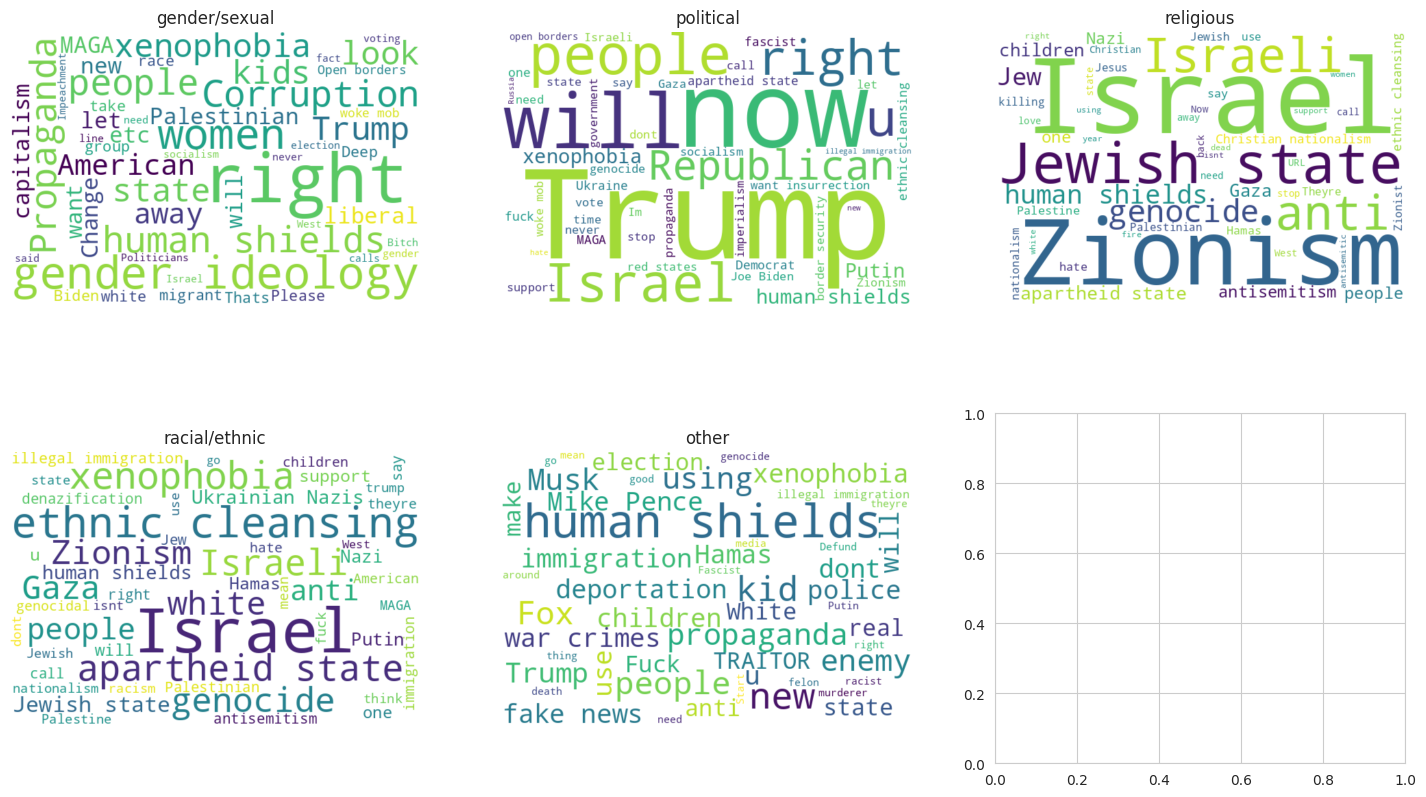

In [ ]:
run_for_languages(['eng'])
